In [1]:
%%capture
%load_ext autoreload
%autoreload 2
from setup_nb_env import *

from epsampling.utils import load_csv
# pd.set_option('display.float_format', lambda x: '%.3f' % x)
from epsampling.utils import drop_sers_with_nans
from epsampling.utils import date_str_to_int

DATA_DIR = '/work/users/k/4/k4thryn/Repos/EpSampling/data/'
DT = datetime.today().strftime('%Y%m%d-%H%M%S')

In [2]:
timestamp = '20241002-004543'
fpath = os.path.join(DATA_DIR,'processed', f'processed_naive_deaths_{timestamp}.csv')
df = pd.read_csv(fpath)
## Drop rows with nans.
df.dropna(inplace=True)
## Drop samples with negative inc deaths.
df_deaths = df[df.True_inc_deaths >= 0]

In [3]:
# # # # # # # # # # # # # # # # # # # # # # # # #
# NAIVE PREDICTION PERFORMANCE FOR EACH COUNTY
# # # # # # # # # # # # # # # # # # # # # # # # #

from epsampling.utils import get_performance
import pprint

county_res_dict = {}

fipss = df_deaths.Fips.unique()

for fips in tqdm(df_deaths.Fips.unique(), total = len(fipss)):
    
    df_fips = df_deaths[df_deaths.Fips==fips]
    
    y_naive = df_fips['Naive_inc_deaths'].values
    y_test = df_fips['True_inc_deaths'].values

    model_names = ['Naive_inc_deaths'] #,'Deaths_true']
    model_preds = [y_naive]
    
    metrics_dict = get_performance(model_names, model_preds, y_test, y_naive)
    county_res_dict[fips] = list(metrics_dict.values())[0]
    
df_res = pd.DataFrame([[county,metric,value] 
                       for county,d in county_res_dict.items() 
                       for metric,value in d.items()], 
                       columns = ['Fips','metric','value'])

df = df_res.pivot(index='Fips',columns='metric',values='value')
# df.drop('relMAE',axis=1,inplace=True)

df.reset_index(inplace=True)
df.columns.name = None
df.index.name = None

dff = df.merge(df_deaths[['Fips','Pop','Ratio']], on='Fips')
dff.drop_duplicates(inplace=True)
df = dff[['Fips', 'Pop', 'Ratio', 'MAE', 'relMAE', 'MSE', 'RMSE', 'r2']]

## compute normalize MAE (divide it by county pop)
df['normMAE'] = df.apply(lambda x: x.MAE / x.Pop, axis=1)

## drop giant county
max_pop = df.Pop.max()
df = df[df.Pop < max_pop]

display(df)

100%|██████████| 3131/3131 [00:06<00:00, 518.00it/s]


,Fips,Pop,Ratio,MAE,relMAE,MSE,RMSE,r2,normMAE
0,1001,58239,0.011653,1.442469,1.0,4.288161,2.070788,0.300375,0.000025
96,1003,227131,0.045447,5.212893,1.0,65.629623,8.101211,0.171386,0.000023
194,1005,25259,0.005054,0.897593,1.0,4.181049,2.044761,0.047110,0.000036
292,1007,22412,0.004484,0.966661,1.0,5.255706,2.292533,0.023673,0.000043
389,1009,58884,0.011782,1.489784,1.0,5.462142,2.337123,0.373556,0.000025
...,...,...,...,...,...,...,...,...,...
306269,56037,42459,0.073632,1.002291,1.0,2.748585,1.657886,0.312222,0.000024
306368,56039,23319,0.040439,0.580852,1.0,0.667827,0.817207,-2.952518,0.000025
306467,56041,20514,0.035575,0.537657,1.0,0.670594,0.818898,-0.011463,0.000026
306566,56043,7768,0.013471,0.472109,1.0,0.945976,0.972613,0.063673,0.000061


In [5]:
## SAVE CSV!
fpath = os.path.join(DATA_DIR,'processed','scratch',f'county_metrics_for_mae_fig_{DT}.csv')
df.to_csv(fpath,index=False)
print(DT)

20241004-193554


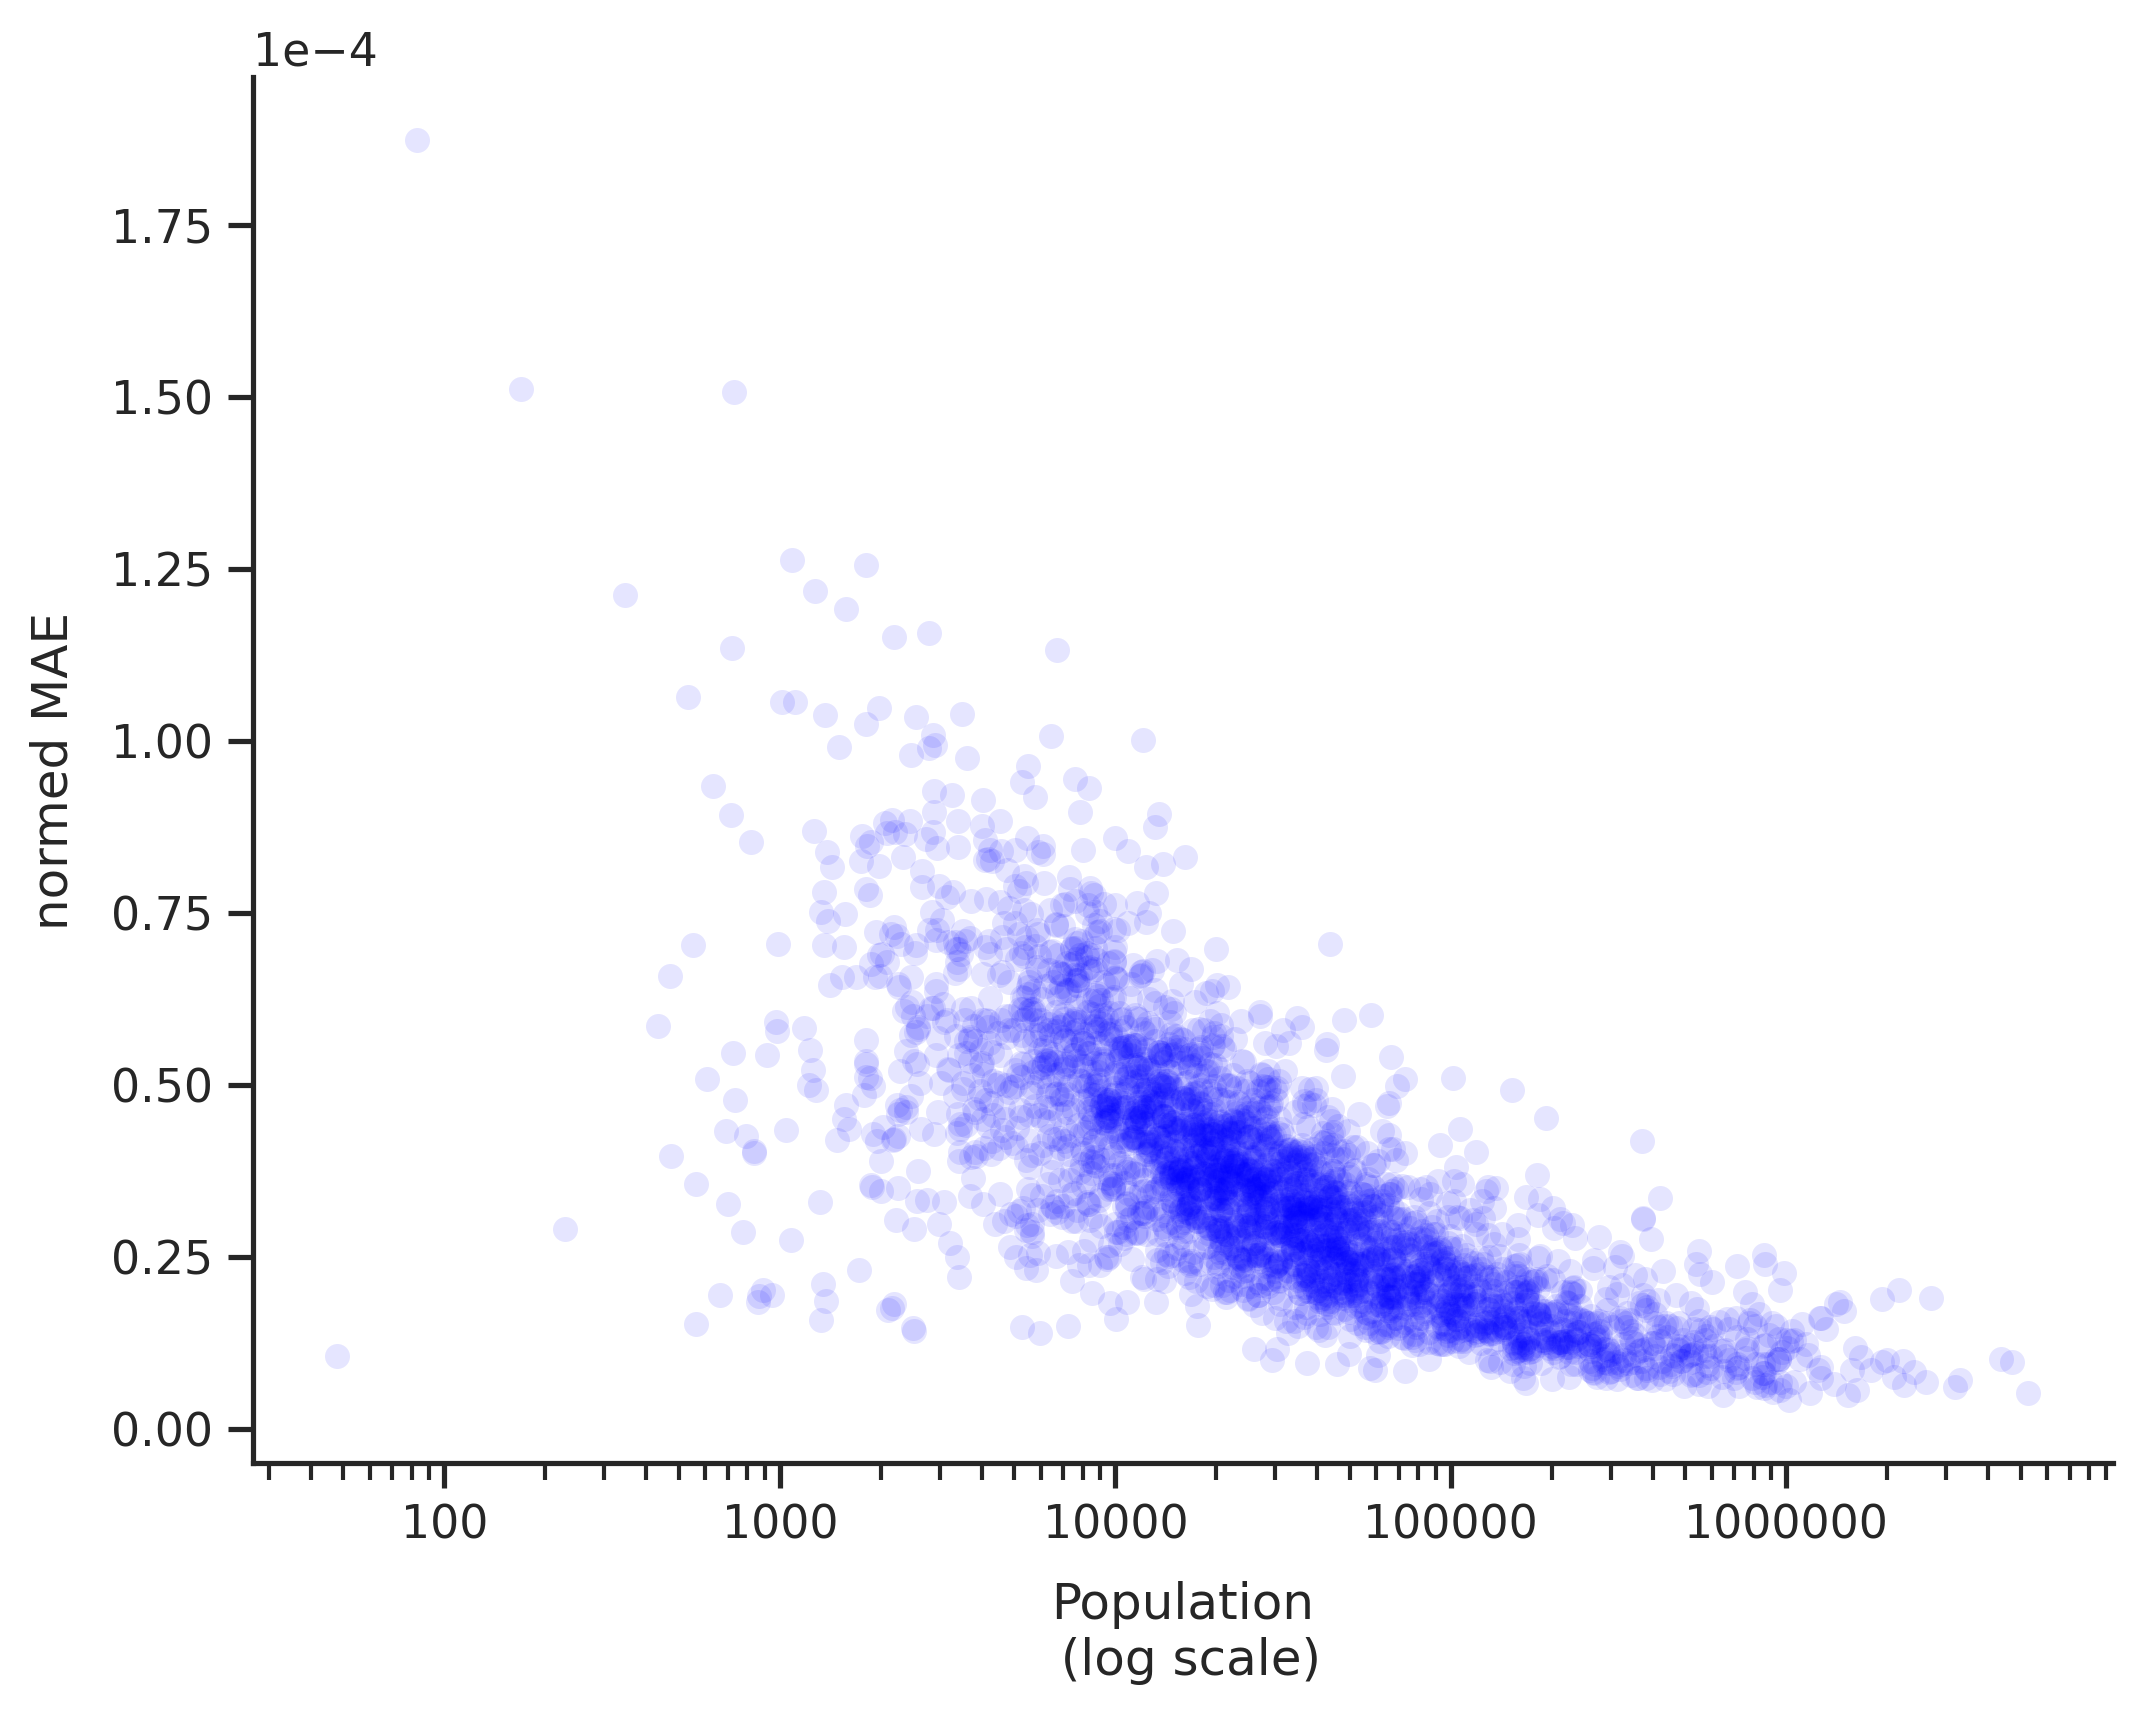

In [7]:
# # # # # # # # # # # # # # # # # # # # # # # # #
# PLOT normMAE vs. COUNTY POPULATION
# # # # # # # # # # # # # # # # # # # # # # # # #

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1, style='ticks') 

from matplotlib import ticker as mtick

metric = 'normMAE'

FIGSIZE = (8,6)
ALPHA = 0.1
SIZES = 2
LINEWIDTH = 0
DPI = 300
LABELPAD = 8
  
plt.figure(figsize=FIGSIZE)
ax = sns.scatterplot(data=df, x="Pop", y=metric, alpha=ALPHA, 
                     sizes=SIZES, linewidth=LINEWIDTH, c='blue')

plt.xlabel('Population\n (log scale)',labelpad=LABELPAD)
# plt.ylabel('MAE (population normed)')
# plt.ylabel(' Mean absolute error\n(normed by population)', labelpad=LABELPAD)
plt.ylabel('normed MAE', labelpad=LABELPAD)

# plt.xt

plt.xscale('log')
xticks = mtick.FormatStrFormatter('%d')
plt.gca().xaxis.set_major_formatter(xticks)

ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

sns.despine()
plt.gcf().set_dpi(DPI)
plt.show()

In [ ]:
LosAngeles, Dade, Maricopa, Philadelphia, Orange, Wake, Anchorage, Bar Harbor

In [32]:
import numpy as np
import scipy.stats

print('normMAE vs. Pop *')
r = scipy.stats.pearsonr(df.normMAE, df.Pop)    # Pearson's r
rho = scipy.stats.spearmanr(df.normMAE, df.Pop)   # Spearman's rho
tau = scipy.stats.kendalltau(df.normMAE, df.Pop)   # Kendall's tau
display(r, rho, tau)


normMAE vs. Pop *


PearsonRResult(statistic=-0.3588419115994992, pvalue=9.291874525618262e-96)

SignificanceResult(statistic=-0.8029067258556304, pvalue=0.0)

SignificanceResult(statistic=-0.6207201815049106, pvalue=0.0)